In [1]:
!pip install datasets
!pip install conlleval
!pip install wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 37.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=f85dfc1b9be0dc3a19dd86d231fcd10beba06b1d939636c4f586d0c0cccf54fc
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [39]:
import datasets
import itertools
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.nn.utils.rnn import pad_sequence
from conlleval import evaluate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from conlleval import evaluate
import itertools
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [40]:
dataset = datasets.load_dataset("conll2003")

In [41]:
# Remove 'pos tags' and 'chunk tags' columns from the dataset
columns_to_remove = ['id', 'pos_tags', 'chunk_tags']
dataset = dataset.remove_columns(columns_to_remove)

# Rename the 'ner' column to 'labels'
dataset = dataset.rename_column('ner_tags', 'labels')

In [42]:
word_frequency = Counter(itertools.chain(*dataset['train']['tokens']))

# Remove words below threshold 3
word_frequency = {
    word: frequency for word, frequency in word_frequency.items() if frequency >= 3
}

word2idx = {
    word: index for index, word in enumerate(word_frequency.keys(), start=2)
}

word2idx['[PAD]'] = 0
word2idx['[UNK]'] = 1

dataset = (
    dataset
    .map(lambda x: {
            'input_ids': [
                word2idx.get(word, word2idx['[UNK]'])
                for word in x['tokens']
            ]
        }
    )
)

In [43]:
# Define a modified collate function to pad sequences and labels with 9 for 0 in input_ids
def collate_fn(batch):
    max_seq_len = max(len(item['input_ids']) for item in batch)
    padded_input_ids = [item['input_ids'] + [0] * (max_seq_len - len(item['input_ids'])) for item in batch]
    padded_labels = [item['labels'] + [9] * (max_seq_len - len(item['labels'])) for item in batch]
    return {
        'input_ids': torch.tensor(padded_input_ids),
        'labels': torch.tensor(padded_labels)
    }

In [44]:
# # Remove 'tokens' column from the dataset
# columns_to_remove = ['tokens']
# dataset = dataset.remove_columns(columns_to_remove)

In [45]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'labels', 'input_ids'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'labels', 'input_ids'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'labels', 'input_ids'],
        num_rows: 3453
    })
})

In [46]:
# Create DataLoader for training, validation, and test datasets using the modified collate function
train_loader = DataLoader(dataset['train'], batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(dataset['validation'], batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(dataset['test'], batch_size=32, collate_fn=collate_fn)

In [47]:
# Map numeric class labels back to tag strings
idx2tag = {idx: tag for idx, tag in enumerate(dataset['train'].features['labels'].feature.names)}
print(idx2tag)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}


# Task 1: Bidirectional LSTM model

Epoch [1/22] - Training Loss: 0.2834, Validation Loss: 0.1570
Epoch [2/22] - Training Loss: 0.0869, Validation Loss: 0.1478
Epoch [3/22] - Training Loss: 0.0613, Validation Loss: 0.1614
Epoch [4/22] - Training Loss: 0.0518, Validation Loss: 0.1689
Epoch [5/22] - Training Loss: 0.0470, Validation Loss: 0.1818
Epoch [6/22] - Training Loss: 0.0265, Validation Loss: 0.1767
Epoch [7/22] - Training Loss: 0.0119, Validation Loss: 0.1974
Epoch [8/22] - Training Loss: 0.0081, Validation Loss: 0.2169
Epoch [9/22] - Training Loss: 0.0057, Validation Loss: 0.2378
Epoch [10/22] - Training Loss: 0.0045, Validation Loss: 0.2547
Epoch [11/22] - Training Loss: 0.0034, Validation Loss: 0.2551
Epoch [12/22] - Training Loss: 0.0031, Validation Loss: 0.2580
Early stopping as validation loss started increasing.




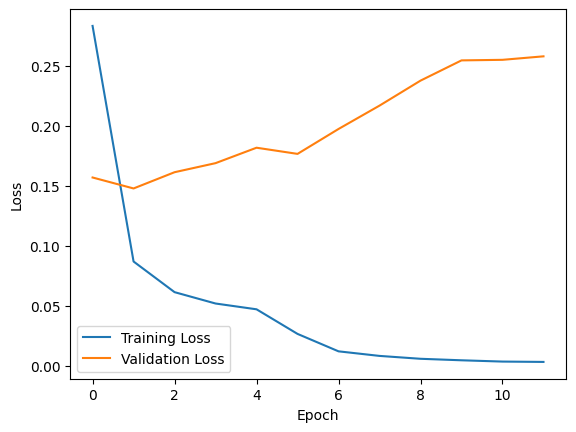


processed 51362 tokens with 5942 phrases; found: 5890 phrases; correct: 4704.
accuracy:  81.74%; (non-O)
accuracy:  95.93%; precision:  79.86%; recall:  79.17%; FB1:  79.51
              LOC: precision:  87.46%; recall:  84.70%; FB1:  86.06  1779
             MISC: precision:  78.37%; recall:  77.01%; FB1:  77.68  906
              ORG: precision:  72.32%; recall:  73.45%; FB1:  72.88  1362
              PER: precision:  78.84%; recall:  78.88%; FB1:  78.86  1843

Validation Precision: 79.8642, Recall: 79.1653, F1 Score: 79.5132

processed 46435 tokens with 5648 phrases; found: 5496 phrases; correct: 3900.
accuracy:  73.80%; (non-O)
accuracy:  93.74%; precision:  70.96%; recall:  69.05%; FB1:  69.99
              LOC: precision:  81.43%; recall:  77.28%; FB1:  79.30  1583
             MISC: precision:  63.55%; recall:  64.81%; FB1:  64.17  716
              ORG: precision:  64.59%; recall:  64.78%; FB1:  64.68  1666
              PER: precision:  70.54%; recall:  66.79%; FB1:  68.61  

In [ ]:
class SimpleBidirectionalLSTM(nn.Module):
    def __init__(self, config):
        super(SimpleBidirectionalLSTM, self).__init__()
        self.embedding = nn.Embedding(config.word_vocab_size, config.embedding_dim, padding_idx=config.input_pad_token_id)
        self.lstm = nn.LSTM(config.embedding_dim, config.lstm_hidden, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2 * config.lstm_hidden, config.linear_output_dim)
        self.elu = nn.ELU()
        self.classifier = nn.Linear(config.linear_output_dim, config.num_classes)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        lstm_out, _ = self.lstm(x)
        linear_out = self.linear(lstm_out)
        elu_out = self.elu(linear_out)
        logits = self.classifier(elu_out)
        return logits

# Define your configuration
class SimpleBidirectionalLSTMConfig:
    word_vocab_size = len(word2idx)
    embedding_dim = 100
    lstm_hidden = 256
    lstm_dropout = 0.33
    linear_output_dim = 128
    num_classes = len(idx2tag)
    input_pad_token_id = 0
    label_pad_token_id = 9
    batch_size = 15
    learning_rate = 0.01
    num_epochs = 22

# Instantiate the model
model = SimpleBidirectionalLSTM(SimpleBidirectionalLSTMConfig())
model = model.to('cuda')

# Define loss function
criterion = nn.CrossEntropyLoss(ignore_index=SimpleBidirectionalLSTMConfig.label_pad_token_id)

# Define optimizer with the learning rate
optimizer = optim.Adam(model.parameters(), lr=SimpleBidirectionalLSTMConfig.learning_rate)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop with overfitting checks
train_losses = []
valid_losses = []

# Training loop
for epoch in range(SimpleBidirectionalLSTMConfig.num_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        input_ids = batch['input_ids'].to('cuda')
        labels = batch['labels'].to('cuda')

        optimizer.zero_grad()
        outputs = model(input_ids)

        loss = criterion(outputs.view(-1, SimpleBidirectionalLSTMConfig.num_classes), labels.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Learning rate scheduling step
    scheduler.step()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    # Validation loss
    model.eval()
    with torch.no_grad():
        total_valid_loss = 0.0
        for valid_batch in valid_loader:
            valid_input_ids = valid_batch['input_ids'].to('cuda')
            valid_labels = valid_batch['labels'].to('cuda')

            valid_outputs = model(valid_input_ids)
            valid_loss = criterion(valid_outputs.view(-1, SimpleBidirectionalLSTMConfig.num_classes), valid_labels.view(-1))
            total_valid_loss += valid_loss.item()

    average_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(average_valid_loss)

    print(f"Epoch [{epoch + 1}/{SimpleBidirectionalLSTMConfig.num_epochs}] - "
          f"Training Loss: {average_loss:.4f}, Validation Loss: {average_valid_loss:.4f}")

    # Early stopping check (you can modify this based on your needs)
    if epoch > 10 and valid_losses[-1] > valid_losses[-2]:
        print("Early stopping as validation loss started increasing.\n")
        break

print()

# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


def evaluate_model_with_padding(model, dataloader, idx2tag, ignore_index=9):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to('cuda')
            labels = batch['labels'].to('cuda')
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=2)

            # Remove predictions for padded tokens
            for i in range(len(input_ids)):
                non_padding_mask = (input_ids[i] != SimpleBidirectionalLSTMConfig.input_pad_token_id).tolist()
                pred_seq = preds[i][non_padding_mask].tolist()
                label_seq = labels[i][non_padding_mask].tolist()

                all_preds.append(pred_seq)
                all_labels.append(label_seq)

    # Map the labels and predictions to tag strings
    labels = [
        list(map(idx2tag.get, label_seq))
        for label_seq in all_labels
    ]
    preds = [
        list(map(idx2tag.get, pred_seq))
        for pred_seq in all_preds
    ]

    # Evaluate precision, recall, and F1 score
    precision, recall, f1 = evaluate(
        itertools.chain(*labels),
        itertools.chain(*preds),
    )

    return precision, recall, f1

print()

# Evaluate on validation data
precision_val, recall_val, f1_val = evaluate_model_with_padding(model, valid_loader, idx2tag)
print(f"\nValidation Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1 Score: {f1_val:.4f}")
print()

# Evaluate on test data
precision_test, recall_test, f1_test = evaluate_model_with_padding(model, test_loader, idx2tag)
print(f"\nTest Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}")

In [ ]:
# # Save the model
# torch.save(model.state_dict(), 'BiLSTM.pth')

# Task 2: Using GloVe word embeddings

In [11]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-11-10 02:33:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-11-10 02:33:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-11-10 02:33:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Epoch [1/22] - Training Loss: 0.2633, Validation Loss: 0.1569
Epoch [2/22] - Training Loss: 0.0868, Validation Loss: 0.1415
Epoch [3/22] - Training Loss: 0.0611, Validation Loss: 0.1587
Epoch [4/22] - Training Loss: 0.0488, Validation Loss: 0.1580
Epoch [5/22] - Training Loss: 0.0434, Validation Loss: 0.1652
Epoch [6/22] - Training Loss: 0.0383, Validation Loss: 0.1838
Epoch [7/22] - Training Loss: 0.0380, Validation Loss: 0.2193
Early stopping as validation loss started increasing.



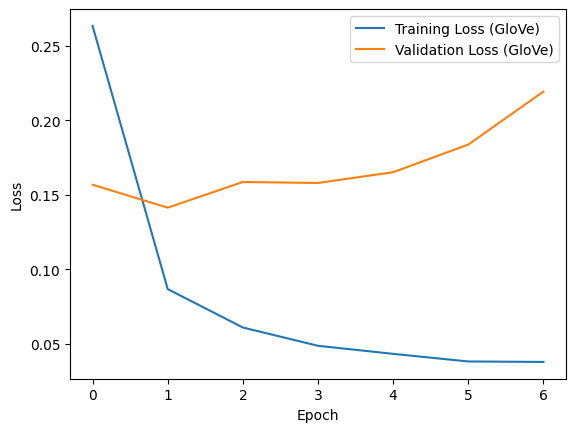


processed 51362 tokens with 5942 phrases; found: 5244 phrases; correct: 4319.
accuracy:  75.36%; (non-O)
accuracy:  95.30%; precision:  82.36%; recall:  72.69%; FB1:  77.22
              LOC: precision:  90.31%; recall:  83.23%; FB1:  86.63  1693
             MISC: precision:  69.50%; recall:  74.40%; FB1:  71.87  987
              ORG: precision:  77.25%; recall:  68.61%; FB1:  72.67  1191
              PER: precision:  86.23%; recall:  64.28%; FB1:  73.65  1373

Validation Precision: 82.3608, Recall: 72.6860, F1 Score: 77.2215

processed 46435 tokens with 5648 phrases; found: 4823 phrases; correct: 3500.
accuracy:  66.42%; (non-O)
accuracy:  92.97%; precision:  72.57%; recall:  61.97%; FB1:  66.85
              LOC: precision:  82.48%; recall:  75.06%; FB1:  78.59  1518
             MISC: precision:  50.70%; recall:  61.82%; FB1:  55.71  856
              ORG: precision:  71.88%; recall:  58.94%; FB1:  64.77  1362
              PER: precision:  76.82%; recall:  51.64%; FB1:  61.76  

In [50]:
# Load GloVe embeddings
vocab, embeddings = [], []
with open('glove.6B.100d.txt', 'rt') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    vocab.append(i_word)
    embeddings.append([float(val) for val in full_content[i].split(' ')[1:]])

# Insert '<pad>' and '<unk>' tokens at the start of vocab.
vocab.insert(0, '[PAD]')
vocab.insert(1, '[UNK]')

# Create word2idx mapping
word2idx = {word: idx for idx, word in enumerate(vocab)}

# Create embedding layer with GloVe embeddings
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embeddings), padding_idx=word2idx['[PAD]'])

# Lowercase the tokens
dataset = (
    dataset
    .map(lambda x: {
        'input_ids': [
            word2idx.get(word.lower(), word2idx['[UNK]'])
            for word in x['tokens']
        ]
    })
)

# Define your configuration
class SimpleBidirectionalLSTMConfig:
    word_vocab_size = len(word2idx)
    embedding_dim = 100
    lstm_hidden = 256
    lstm_dropout = 0.33
    linear_output_dim = 128
    num_classes = len(idx2tag)
    input_pad_token_id = 0
    label_pad_token_id = 9
    batch_size = 32
    learning_rate = 0.01
    num_epochs = 22


# Define the model with GloVe embeddings
class CaseSensitiveBidirectionalLSTM(nn.Module):
    def __init__(self, config, embedding_layer):
        super(CaseSensitiveBidirectionalLSTM, self).__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(config.embedding_dim, config.lstm_hidden, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2 * config.lstm_hidden, config.linear_output_dim)
        self.elu = nn.ELU()
        self.classifier = nn.Linear(config.linear_output_dim, config.num_classes)

        # Freeze lowercase embeddings
        self.embedding.weight.requires_grad = False
        lowercase_indices = [word2idx[word.lower()] for word in word_frequency.keys() if word.lower() in word2idx]
        lowercase_mask = torch.zeros_like(self.embedding.weight, dtype=torch.bool)
        lowercase_mask[lowercase_indices] = True
        self.embedding.weight[lowercase_mask] = 0  # Set lowercase embeddings to zero
        self.embedding.weight.requires_grad = True  # Allow only capitalized embeddings to be updated


    def forward(self, input_ids):
        x = self.embedding(input_ids)
        lstm_out, _ = self.lstm(x)
        linear_out = self.linear(lstm_out)
        elu_out = self.elu(linear_out)
        logits = self.classifier(elu_out)
        return logits

# Instantiate the model with GloVe embeddings
model_glove = CaseSensitiveBidirectionalLSTM(SimpleBidirectionalLSTMConfig(), embedding_layer)
model_glove = model_glove.to('cuda')

# Define loss function
criterion = nn.CrossEntropyLoss(ignore_index=SimpleBidirectionalLSTMConfig.label_pad_token_id)

# Define optimizer with the learning rate for trainable parameters
optimizer_glove = optim.Adam(filter(lambda p: p.requires_grad, model_glove.parameters()), lr=SimpleBidirectionalLSTMConfig.learning_rate)

# Learning rate scheduler
scheduler_glove = StepLR(optimizer_glove, step_size=9, gamma=0.1)

# Training loop with overfitting checks
train_losses_glove = []
valid_losses_glove = []

# Training loop
for epoch in range(SimpleBidirectionalLSTMConfig.num_epochs):
    model_glove.train()
    total_loss = 0.0

    for batch in train_loader:
        input_ids = batch['input_ids'].to('cuda')
        labels = batch['labels'].to('cuda')

        optimizer_glove.zero_grad()
        outputs = model_glove(input_ids)

        loss = criterion(outputs.view(-1, SimpleBidirectionalLSTMConfig.num_classes), labels.view(-1))
        loss.backward()
        optimizer_glove.step()

        total_loss += loss.item()

    # Learning rate scheduling step
    scheduler_glove.step()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(train_loader)
    train_losses_glove.append(average_loss)

    # Validation loss
    model_glove.eval()
    with torch.no_grad():
        total_valid_loss = 0.0
        for valid_batch in valid_loader:
            valid_input_ids = valid_batch['input_ids'].to('cuda')
            valid_labels = valid_batch['labels'].to('cuda')

            valid_outputs = model_glove(valid_input_ids)
            valid_loss = criterion(valid_outputs.view(-1, SimpleBidirectionalLSTMConfig.num_classes),
                                   valid_labels.view(-1))
            total_valid_loss += valid_loss.item()

    average_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses_glove.append(average_valid_loss)

    print(f"Epoch [{epoch + 1}/{SimpleBidirectionalLSTMConfig.num_epochs}] - "
          f"Training Loss: {average_loss:.4f}, Validation Loss: {average_valid_loss:.4f}")

    # Early stopping check (you can modify this based on your needs)
    if epoch > 5 and valid_losses_glove[-1] > valid_losses_glove[-2]:
        print("Early stopping as validation loss started increasing.\n")
        break

# Plot the training and validation loss for the model with GloVe embeddings
plt.plot(train_losses_glove, label='Training Loss (GloVe)')
plt.plot(valid_losses_glove, label='Validation Loss (GloVe)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print()

def evaluate_model_with_padding(model, dataloader, idx2tag, ignore_index=9):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to('cuda')
            labels = batch['labels'].to('cuda')
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=2)

            # Remove predictions for padded tokens
            for i in range(len(input_ids)):
                non_padding_mask = (input_ids[i] != SimpleBidirectionalLSTMConfig.input_pad_token_id).tolist()
                pred_seq = preds[i][non_padding_mask].tolist()
                label_seq = labels[i][non_padding_mask].tolist()

                all_preds.append(pred_seq)
                all_labels.append(label_seq)

    # Map the labels and predictions to tag strings
    labels = [
        list(map(idx2tag.get, label_seq))
        for label_seq in all_labels
    ]
    preds = [
        list(map(idx2tag.get, pred_seq))
        for pred_seq in all_preds
    ]

    # Evaluate precision, recall, and F1 score
    precision, recall, f1 = evaluate(
        itertools.chain(*labels),
        itertools.chain(*preds),
    )

    return precision, recall, f1

# Evaluate on validation data
precision_val_glove, recall_val_glove, f1_val_glove = evaluate_model_with_padding(model_glove, valid_loader, idx2tag)
print(f"\nValidation Precision: {precision_val_glove:.4f}, Recall: {recall_val_glove:.4f}, F1 Score: {f1_val_glove:.4f}")
print()

# Evaluate on test data
precision_test_glove, recall_test_glove, f1_test_glove = evaluate_model_with_padding(model_glove, test_loader, idx2tag)
print(f"\nTest Precision: {precision_test_glove:.4f}, Recall: {recall_test_glove:.4f}, F1 Score: {f1_test_glove:.4f}")

In [ ]:
vocab,embeddings = [],[]
with open('glove.6B.100d.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

In [ ]:
vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

In [ ]:
#insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab_npa = np.insert(vocab_npa, 0, '<pad>')
vocab_npa = np.insert(vocab_npa, 1, '<unk>')
print(vocab_npa[:10])

pad_emb_npa = np.zeros((1,embs_npa.shape[1]))   #embedding for '<pad>' token.
unk_emb_npa = np.mean(embs_npa,axis=0,keepdims=True)    #embedding for '<unk>' token.

#insert embeddings for pad and unk tokens at top of embs_npa.
embs_npa = np.vstack((pad_emb_npa,unk_emb_npa,embs_npa))
print(embs_npa.shape)

['<pad>' '<unk>' 'the' ',' '.' 'of' 'to' 'and' 'in' 'a']
(400002, 100)


In [ ]:
# Create an embedding layer with GloVe embeddings
glove_embedding_layer = nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float(), padding_idx=0)


assert glove_embedding_layer.weight.shape == embs_npa.shape
print(glove_embedding_layer.weight.shape)

torch.Size([400002, 100])


In [22]:
# # Update your dataset creation to include casing features
# def create_dataset_with_casing(data, word2idx):
#     datasets = []
#     for split in data:
#         new_data = []
#         for entry in data[split]:
#             tokens = entry['tokens']
#             casing_features = [
#                 [int(word[0].isupper()), int(word.isupper())] for word in tokens
#             ]
#             new_entry = {
#                 'input_ids': [word2idx.get(word, word2idx['[UNK]']) for word in tokens],
#                 'labels': entry['labels'],
#                 'casing_features': casing_features
#             }
#             new_data.append(new_entry)
#         datasets.append((split, new_data))
#     return dict(datasets)

# Update casing features in dataset creation
def create_dataset_with_casing(data, word2idx):
    datasets = []
    for split in data:
        new_data = []
        for entry in data[split]:
            tokens = entry['tokens']
            casing_features = [
                [
                    # int(word[0].isupper()),
                    int(word.isupper()),
                    int(word.islower()),
                    # int(word.isdigit())
                ] for word in tokens
            ]
            new_entry = {
                'input_ids': [word2idx.get(word, word2idx['[UNK]']) for word in tokens],
                'labels': entry['labels'],
                'casing_features': casing_features
            }
            new_data.append(new_entry)
        datasets.append((split, new_data))
    return dict(datasets)

# Update the dataset
dataset_with_casing = create_dataset_with_casing(dataset, word2idx)

In [23]:
# Modify the collate function in the DataLoader to handle casing features
def collate_fn_with_casing(batch):
    max_seq_len = max(len(item['input_ids']) for item in batch)
    padded_input_ids = [item['input_ids'] + [0] * (max_seq_len - len(item['input_ids'])) for item in batch]
    padded_labels = [item['labels'] + [9] * (max_seq_len - len(item['labels'])) for item in batch]
    # Add casing features to the input batch
    casing_features = [item['casing_features'] + [[0, 0]] * (max_seq_len - len(item['casing_features'])) for item in batch]
    return {
        'input_ids': torch.tensor(padded_input_ids),
        'labels': torch.tensor(padded_labels),
        'casing_features': torch.tensor(casing_features)
    }

# Create DataLoader for training, validation, and test datasets using the modified collate function
train_loader_with_casing = DataLoader(dataset_with_casing['train'], batch_size=32, shuffle=True, collate_fn=collate_fn_with_casing)
valid_loader_with_casing = DataLoader(dataset_with_casing['validation'], batch_size=32, collate_fn=collate_fn_with_casing)
test_loader_with_casing = DataLoader(dataset_with_casing['test'], batch_size=32, collate_fn=collate_fn_with_casing)

Epoch [1/22] - Training Loss: 0.3324, Validation Loss: 0.2534
Epoch [2/22] - Training Loss: 0.1362, Validation Loss: 0.1887
Epoch [3/22] - Training Loss: 0.0840, Validation Loss: 0.2380
Epoch [4/22] - Training Loss: 0.0575, Validation Loss: 0.2571
Epoch [5/22] - Training Loss: 0.0452, Validation Loss: 0.2840
Epoch [6/22] - Training Loss: 0.0200, Validation Loss: 0.2930
Epoch [7/22] - Training Loss: 0.0056, Validation Loss: 0.3257
Epoch [8/22] - Training Loss: 0.0025, Validation Loss: 0.3521
Epoch [9/22] - Training Loss: 0.0013, Validation Loss: 0.3751
Epoch [10/22] - Training Loss: 0.0008, Validation Loss: 0.3917
Epoch [11/22] - Training Loss: 0.0005, Validation Loss: 0.3940
Epoch [12/22] - Training Loss: 0.0005, Validation Loss: 0.3963
Early stopping as validation loss started increasing.




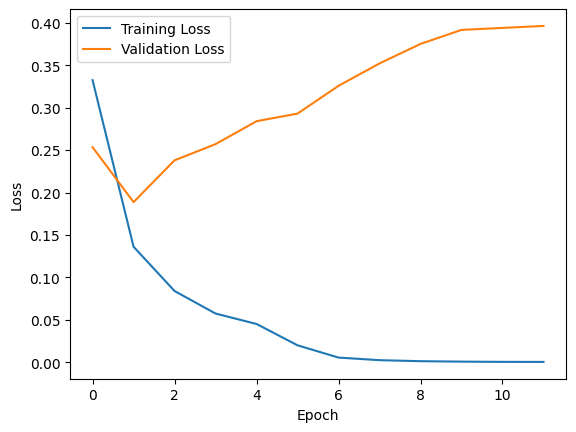


processed 51362 tokens with 5942 phrases; found: 6294 phrases; correct: 4620.
accuracy:  79.27%; (non-O)
accuracy:  95.48%; precision:  73.40%; recall:  77.75%; FB1:  75.51
              LOC: precision:  70.15%; recall:  84.81%; FB1:  76.79  2221
             MISC: precision:  79.91%; recall:  75.92%; FB1:  77.86  876
              ORG: precision:  72.73%; recall:  70.40%; FB1:  71.54  1298
              PER: precision:  74.67%; recall:  76.98%; FB1:  75.81  1899

Validation Precision: 73.4032, Recall: 77.7516, F1 Score: 75.5149

processed 46435 tokens with 5648 phrases; found: 6245 phrases; correct: 3858.
accuracy:  71.41%; (non-O)
accuracy:  92.73%; precision:  61.78%; recall:  68.31%; FB1:  64.88
              LOC: precision:  60.25%; recall:  75.78%; FB1:  67.13  2098
             MISC: precision:  61.94%; recall:  62.82%; FB1:  62.38  712
              ORG: precision:  61.40%; recall:  64.36%; FB1:  62.85  1741
              PER: precision:  63.99%; recall:  67.04%; FB1:  65.48  

In [ ]:
# Define the SimpleBidirectionalLSTM model with GloVe embeddings and casing features
class SimpleBidirectionalLSTMWithGloVe(nn.Module):
    def __init__(self, config, embedding_layer):
        super(SimpleBidirectionalLSTMWithGloVe, self).__init__()
        self.embedding = embedding_layer
        self.embedding_dim = config.embedding_dim
        self.lstm = nn.LSTM(
            input_size=config.embedding_dim + len(casing_feature_names),
            hidden_size=config.lstm_hidden,
            batch_first=True,
            bidirectional=True
        )
        self.linear = nn.Linear(2 * config.lstm_hidden, config.linear_output_dim)
        self.elu = nn.ELU()
        self.classifier = nn.Linear(config.linear_output_dim, config.num_classes)

    def forward(self, input_ids, casing_features):
        glove_embeddings = self.embedding(input_ids)
        x = torch.cat([glove_embeddings, casing_features], dim=-1)
        lstm_out, _ = self.lstm(x)
        linear_out = self.linear(lstm_out)
        elu_out = self.elu(linear_out)
        logits = self.classifier(elu_out)
        return logits

# Add casing feature names
# casing_feature_names = ['StartsWithCapital', 'AllCapital', 'AllLowerCase', 'AllDigits']
casing_feature_names = ['AllCapital', 'AllLowerCase']
word2idx_casing = {feature: idx + 2 for idx, feature in enumerate(casing_feature_names)}
word2idx_casing['<pad>'] = 0
word2idx_casing['<unk>'] = 1


# Define your configuration
class SimpleBidirectionalLSTMConfig:
    word_vocab_size = len(vocab_npa)
    casing_vocab_size = len(word2idx_casing)
    embedding_dim = 100
    lstm_hidden = 256
    lstm_dropout = 0.33
    linear_output_dim = 128
    num_classes = len(idx2tag)
    input_pad_token_id = 0
    label_pad_token_id = 9
    batch_size = 15
    learning_rate = 0.01
    num_epochs = 22

# Instantiate the model with GloVe embeddings and casing features
model_with_glove_casing = SimpleBidirectionalLSTMWithGloVe(SimpleBidirectionalLSTMConfig(), glove_embedding_layer)
model_with_glove_casing = model_with_glove_casing.to('cuda')

# Set requires_grad to False for the embedding layer to freeze it
glove_embedding_layer.requires_grad = False

# Define loss function
criterion = nn.CrossEntropyLoss(ignore_index=SimpleBidirectionalLSTMConfig.label_pad_token_id)

# Define optimizer with the learning rate
optimizer = optim.Adam(model_with_glove_casing.parameters(), lr=SimpleBidirectionalLSTMConfig.learning_rate)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop with overfitting checks
train_losses = []
valid_losses = []

# Training loop
for epoch in range(SimpleBidirectionalLSTMConfig.num_epochs):
    model_with_glove_casing.train()
    total_loss = 0.0

    for batch in train_loader_with_casing:  # Use the DataLoader with casing features
        input_ids = batch['input_ids'].to('cuda')
        casing_features = batch['casing_features'].to('cuda')  # Add casing features
        labels = batch['labels'].to('cuda')

        optimizer.zero_grad()
        outputs = model_with_glove_casing(input_ids, casing_features)

        loss = criterion(outputs.view(-1, SimpleBidirectionalLSTMConfig.num_classes), labels.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Learning rate scheduling step
    scheduler.step()

    # Calculate average loss for the epoch
    average_loss = total_loss / len(train_loader_with_casing)
    train_losses.append(average_loss)

    # Validation loss
    model_with_glove_casing.eval()
    with torch.no_grad():
        total_valid_loss = 0.0
        for valid_batch in valid_loader_with_casing:  # Use the DataLoader with casing features
            valid_input_ids = valid_batch['input_ids'].to('cuda')
            valid_casing_features = valid_batch['casing_features'].to('cuda')  # Add casing features
            valid_labels = valid_batch['labels'].to('cuda')

            valid_outputs = model_with_glove_casing(valid_input_ids, valid_casing_features)
            valid_loss = criterion(valid_outputs.view(-1, SimpleBidirectionalLSTMConfig.num_classes),
                                   valid_labels.view(-1))
            total_valid_loss += valid_loss.item()

    average_valid_loss = total_valid_loss / len(valid_loader_with_casing)
    valid_losses.append(average_valid_loss)

    print(f"Epoch [{epoch + 1}/{SimpleBidirectionalLSTMConfig.num_epochs}] - "
          f"Training Loss: {average_loss:.4f}, Validation Loss: {average_valid_loss:.4f}")

    # Early stopping check (you can modify this based on your needs)
    if epoch > 10 and valid_losses[-1] > valid_losses[-2]:
        print("Early stopping as validation loss started increasing.\n")
        break

print()

# Plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print()

def evaluate_model_with_padding(model, dataloader, idx2tag, word2idx_casing, ignore_index=9):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to('cuda')
            casing_features = batch['casing_features'].to('cuda')  # Add this line
            labels = batch['labels'].to('cuda')
            outputs = model(input_ids, casing_features)  # Include casing_features here
            preds = torch.argmax(outputs, dim=2)

            # Remove predictions for padded tokens
            for i in range(len(input_ids)):
                non_padding_mask = (input_ids[i] != SimpleBidirectionalLSTMConfig.input_pad_token_id).tolist()
                pred_seq = preds[i][non_padding_mask].tolist()
                label_seq = labels[i][non_padding_mask].tolist()

                all_preds.append(pred_seq)
                all_labels.append(label_seq)

    # Map the labels and predictions to tag strings
    labels = [
        list(map(idx2tag.get, label_seq))
        for label_seq in all_labels
    ]
    preds = [
        list(map(idx2tag.get, pred_seq))
        for pred_seq in all_preds
    ]

    # Evaluate precision, recall, and F1 score
    precision, recall, f1 = evaluate(
        itertools.chain(*labels),
        itertools.chain(*preds),
    )

    return precision, recall, f1

# Evaluate on validation data
precision_val, recall_val, f1_val = evaluate_model_with_padding(model_with_glove_casing, valid_loader_with_casing, idx2tag, word2idx_casing)
print(f"\nValidation Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1 Score: {f1_val:.4f}")
print()

# Evaluate on test data
precision_test, recall_test, f1_test = evaluate_model_with_padding(model_with_glove_casing, test_loader_with_casing, idx2tag, word2idx_casing)
print(f"\nTest Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}")